<a href="https://colab.research.google.com/github/skku-kdj/MLRobustness_eval/blob/main/learning_pytorch/Advance_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Resnet, VGG, Dencenet Implementation by pytorch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/colab_files/imagenet64

checkpoint-10.pkl  checkpoint-15.pkl  checkpoint-1.pkl	 checkpoint-5.pkl  imagenet64.tar
checkpoint-11.pkl  checkpoint-16.pkl  checkpoint-20.pkl  checkpoint-6.pkl
checkpoint-12.pkl  checkpoint-17.pkl  checkpoint-2.pkl	 checkpoint-7.pkl
checkpoint-13.pkl  checkpoint-18.pkl  checkpoint-3.pkl	 checkpoint-8.pkl
checkpoint-14.pkl  checkpoint-19.pkl  checkpoint-4.pkl	 checkpoint-9.pkl


In [ ]:
import os
import shutil
if not os.path.exists('imagenet64'):
  if not os.path.exists(checkpoints + 'imagenet64.tar'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    !wget https://pjreddie.com/media/files/imagenet64.tar
    os.chdir('/content/')
  print("Copying to local runtime...")
  shutil.copy(checkpoints + 'imagenet64.tar', './imagenet64.tar')
  print("Uncompressing...")
  !tar -xf imagenet64.tar
print("Data ready!")

Copying to local runtime...
Uncompressing...
Data ready!


In [ ]:
def get_imagenet64_data():
  transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
  ])

  transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

  return {'train': trainloader, 'test': testloader}

data = get_imagenet64_data()

torch.Size([8, 3, 224, 224])


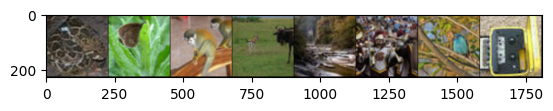

Labels:tensor(67) tensor(322) tensor(381) tensor(353) tensor(979) tensor(875) tensor(14) tensor(848)
torch.Size([8, 3, 224, 224])
torch.Size([8, 150528])


In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

In [ ]:
from torch import nn

class Conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, activation=True, **kwargs) -> None:
    super(Conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs) # kernel size = ...
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.activation = activation

  def forward(self, x):
    if not self.activation:
      return self.batchnorm(self.conv(x))
    return self.relu(self.batchnorm(self.conv(x)))

In [ ]:
class Res_block(nn.Module):
  def __init__(self, in_channels, red_channels, out_channels, is_plain=False):
    super(Res_block,self).__init__()
    self.relu = nn.ReLU()
    self.is_plain = is_plain

    if in_channels==64:
      self.convseq = nn.Sequential(
                                  Conv_block(in_channels, red_channels, kernel_size=1, padding=0),
                                  Conv_block(red_channels, red_channels, kernel_size=3, padding=1),
                                  Conv_block(red_channels, out_channels, activation=False, kernel_size=1, padding=0)
      )
      self.iden = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
    elif in_channels == out_channels:
      self.convseq = nn.Sequential(
                                  Conv_block(in_channels, red_channels, kernel_size=1, padding=0),
                                  Conv_block(red_channels, red_channels, kernel_size=3, padding=1),
                                  Conv_block(red_channels, out_channels, activation=False, kernel_size=1, padding=0)
      )
      self.iden = nn.Identity()
    else:
      self.convseq = nn.Sequential(
                                  Conv_block(in_channels, red_channels, kernel_size=1, padding=0, stride=2),
                                  Conv_block(red_channels, red_channels, kernel_size=3, padding=1),
                                  Conv_block(red_channels, out_channels, activation=False, kernel_size=1, padding=0)

      )
      self.iden = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)

  def forward(self, x):
    y = self.convseq(x)
    if self.is_plain:
      x = y
    else:
      x = y + self.iden(x)
    x = self.relu(x)  # relu(skip connection)
    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self, in_channels=3 , num_classes=1000, is_plain=False):
    self.num_classes = num_classes
    super(ResNet, self).__init__()
    self.conv1 = Conv_block(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv2_x = nn.Sequential(
                                  Res_block(64, 64, 256, is_plain),
                                  Res_block(256, 64, 256, is_plain),
                                  Res_block(256, 64, 256, is_plain)
    )

    self.conv3_x = nn.Sequential(
                                  Res_block(256, 128, 512, is_plain),
                                  Res_block(512, 128, 512, is_plain),
                                  Res_block(512, 128, 512, is_plain),
                                  Res_block(512, 128, 512, is_plain)
    )

    self.conv4_x = nn.Sequential(
                                  Res_block(512, 256, 1024, is_plain),
                                  Res_block(1024, 256, 1024, is_plain),
                                  Res_block(1024, 256, 1024, is_plain),
                                  Res_block(1024, 256, 1024, is_plain),
                                  Res_block(1024, 256, 1024, is_plain),
                                  Res_block(1024, 256, 1024, is_plain)
    )

    self.conv5_x = nn.Sequential(
                                  Res_block(1024, 512, 2048, is_plain),
                                  Res_block(2048, 512, 2048, is_plain),
                                  Res_block(2048, 512, 2048, is_plain),
    )

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.fc = nn.Linear(2048,num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary as summary_

def build_resnet(input_shape=(3, 224, 224), is_50=True, is_plain=False, **kwargs):
  x = torch.randn(2, *input_shape).to(device)
  if is_50:
    model = ResNet(is_plain=is_plain, **kwargs).to(device)
    assert model(x).shape == torch.Size([2, model.num_classes])
    if is_plain == False:
      print("ResNet50 Created")
    if is_plain == True:
      print("PlainNet50 Created")
    print(summary_(model, (3, 224, 224), batch_size=2))
    return model
  model = ResNet_34(is_plain=is_plain).to(device)
  assert model(x).shape == torch.Size([2, model.num_classes])
  if is_plain == False:
    print("ResNet34 Created")
  if is_plain == True:
    print("PlainNet34 Created")
  print(summary_(model, (3, 224, 224), batch_size=2))
  return model

In [ ]:
res_50 = build_resnet(is_plain=False, num_classes=1000)

ResNet50 Created
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 112, 112]           9,472
       BatchNorm2d-2          [2, 64, 112, 112]             128
              ReLU-3          [2, 64, 112, 112]               0
        Conv_block-4          [2, 64, 112, 112]               0
         MaxPool2d-5            [2, 64, 56, 56]               0
            Conv2d-6            [2, 64, 56, 56]           4,160
       BatchNorm2d-7            [2, 64, 56, 56]             128
              ReLU-8            [2, 64, 56, 56]               0
        Conv_block-9            [2, 64, 56, 56]               0
           Conv2d-10            [2, 64, 56, 56]          36,928
      BatchNorm2d-11            [2, 64, 56, 56]             128
             ReLU-12            [2, 64, 56, 56]               0
       Conv_block-13            [2, 64, 56, 56]               0
           Conv2d-14  

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=10, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
      inputs, labels = batch[0].to(device), batch[1].to(device)

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()  # autograd magic, computes all the partial derivatives
      optimizer.step() # takes a step in gradient direction

      losses.append(loss.item())
      sum_loss += loss.item()

      if i % print_every == print_every-1:    # print every 10 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
        sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader:
      images, labels = batch[0].to(device), batch[1].to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
!wget https://pjreddie.com/media/files/checkpoint-19.pkl
!mv checkpoint-19.pkl {checkpoints}
!ls drive/MyDrive/colab_files/imagenet64/

--2023-12-07 06:34:46--  https://pjreddie.com/media/files/checkpoint-19.pkl
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6933096 (6.6M) [application/octet-stream]
Saving to: ‘checkpoint-19.pkl’

checkpoint-19.pkl   100%[===================>]   6.61M  4.82MB/s    in 1.4s    

2023-12-07 06:34:48 (4.82 MB/s) - ‘checkpoint-19.pkl’ saved [6933096/6933096]

checkpoint-19.pkl  checkpoint-1.pkl  imagenet64.tar


In [ ]:
net = ResNet()
losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Learning rate: 0.100000
[0,    10] loss: 8.566
[0,    20] loss: 7.539
[0,    30] loss: 7.160
[0,    40] loss: 7.056
[0,    50] loss: 6.973
[0,    60] loss: 7.168
[0,    70] loss: 6.980
[0,    80] loss: 6.931
[0,    90] loss: 6.923
[0,   100] loss: 6.954
[0,   110] loss: 6.930
[0,   120] loss: 6.907
[0,   130] loss: 12.140
[0,   140] loss: 6.956
[0,   150] loss: 6.919
[0,   160] loss: 6.913
[0,   170] loss: 6.913
[0,   180] loss: 6.925
[0,   190] loss: 6.911
[0,   200] loss: 6.915
[0,   210] loss: 6.905
[0,   220] loss: 6.916
[0,   230] loss: 6.906
[0,   240] loss: 6.901
[0,   250] loss: 6.902
[0,   260] loss: 6.908
[0,   270] loss: 6.902
[0,   280] loss: 6.896
[0,   290] loss: 6.906
[0,   300] loss: 6.906
[0,   310] loss: 6.903
[0,   320] loss: 6.893
[0,   330] loss: 6.901
[0,   340] loss: 6.903
[0,   350] loss: 6.902
[0,   360] loss: 6.906
[0,   370] loss: 6.910
[0,   380] loss: 6.897
[0,   390] loss: 6.904
[0,   400] loss: 6.895
[0,   410] loss: 6.912
[0,   420] loss: 6.904
[0,   430

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[0,  1580] loss: 6.703
[0,  1590] loss: 6.689
[0,  1600] loss: 6.681
[0,  1610] loss: 6.711
[0,  1620] loss: 6.680
[0,  1630] loss: 6.685
[0,  1640] loss: 6.650
[0,  1650] loss: 6.662
[0,  1660] loss: 6.612
[0,  1670] loss: 6.622
[0,  1680] loss: 6.652
[0,  1690] loss: 6.629
[0,  1700] loss: 6.659
[0,  1710] loss: 6.633
[0,  1720] loss: 6.581
[0,  1730] loss: 6.638
[0,  1740] loss: 6.667
[0,  1750] loss: 6.626
[0,  1760] loss: 6.597
[0,  1770] loss: 6.623
[0,  1780] loss: 6.653
[0,  1790] loss: 6.650
[0,  1800] loss: 6.629
[0,  1810] loss: 6.599
[0,  1820] loss: 6.633
[0,  1830] loss: 6.611
[0,  1840] loss: 6.627
[0,  1850] loss: 6.645
[0,  1860] loss: 6.587
[0,  1870] loss: 6.562
[0,  1880] loss: 6.592
[0,  1890] loss: 6.601
[0,  1900] loss: 6.582
[0,  1910] loss: 6.582
[0,  1920] loss: 6.594
[0,  1930] loss: 6.556
[0,  1940] loss: 6.570
[0,  1950] loss: 6.574
[0,  1960] loss: 6.580
[0,  1970] loss: 6.531
[0,  1980] loss: 6.541
[0,  1990] loss: 6.603
[0,  2000] loss: 6.594
[0,  2010] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[0,  7360] loss: 5.009
[0,  7370] loss: 5.027
[0,  7380] loss: 5.002
[0,  7390] loss: 5.040
[0,  7400] loss: 5.072
[0,  7410] loss: 5.000
[0,  7420] loss: 5.051
[0,  7430] loss: 5.001
[0,  7440] loss: 4.913
[0,  7450] loss: 5.013
[0,  7460] loss: 5.040
[0,  7470] loss: 4.907
[0,  7480] loss: 5.037
[0,  7490] loss: 5.080
[0,  7500] loss: 5.047
[0,  7510] loss: 5.060
[0,  7520] loss: 4.997
[0,  7530] loss: 5.042
[0,  7540] loss: 5.103
[0,  7550] loss: 5.014
[0,  7560] loss: 4.911
[0,  7570] loss: 4.975
[0,  7580] loss: 5.095
[0,  7590] loss: 5.054
[0,  7600] loss: 5.130
[0,  7610] loss: 5.035
[0,  7620] loss: 5.069
[0,  7630] loss: 5.051
[0,  7640] loss: 5.117
[0,  7650] loss: 5.014
[0,  7660] loss: 5.007
[0,  7670] loss: 5.049
[0,  7680] loss: 4.983
[0,  7690] loss: 4.950
[0,  7700] loss: 5.015
[0,  7710] loss: 5.031
[0,  7720] loss: 5.026
[0,  7730] loss: 5.039
[0,  7740] loss: 4.916
[0,  7750] loss: 4.983
[0,  7760] loss: 4.960
[0,  7770] loss: 5.065
[0,  7780] loss: 5.079
[0,  7790] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[1,  1330] loss: 4.561
[1,  1340] loss: 4.646
[1,  1350] loss: 4.682
[1,  1360] loss: 4.659
[1,  1370] loss: 4.686
[1,  1380] loss: 4.634
[1,  1390] loss: 4.695
[1,  1400] loss: 4.737
[1,  1410] loss: 4.694
[1,  1420] loss: 4.733
[1,  1430] loss: 4.554
[1,  1440] loss: 4.673
[1,  1450] loss: 4.731
[1,  1460] loss: 4.654
[1,  1470] loss: 4.617
[1,  1480] loss: 4.684
[1,  1490] loss: 4.675
[1,  1500] loss: 4.519
[1,  1510] loss: 4.673
[1,  1520] loss: 4.592
[1,  1530] loss: 4.573
[1,  1540] loss: 4.689
[1,  1550] loss: 4.583
[1,  1560] loss: 4.657
[1,  1570] loss: 4.596
[1,  1580] loss: 4.720
[1,  1590] loss: 4.632
[1,  1600] loss: 4.640
[1,  1610] loss: 4.615
[1,  1620] loss: 4.517
[1,  1630] loss: 4.642
[1,  1640] loss: 4.530
[1,  1650] loss: 4.468
[1,  1660] loss: 4.633
[1,  1670] loss: 4.763
[1,  1680] loss: 4.600
[1,  1690] loss: 4.746
[1,  1700] loss: 4.705
[1,  1710] loss: 4.591
[1,  1720] loss: 4.579
[1,  1730] loss: 4.637
[1,  1740] loss: 4.652
[1,  1750] loss: 4.714
[1,  1760] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  1700] loss: 4.162
[2,  1710] loss: 4.136
[2,  1720] loss: 4.235
[2,  1730] loss: 4.287
[2,  1740] loss: 4.209
[2,  1750] loss: 4.208
[2,  1760] loss: 4.288
[2,  1770] loss: 4.229
[2,  1780] loss: 4.238
[2,  1790] loss: 4.285
[2,  1800] loss: 4.136
[2,  1810] loss: 4.243
[2,  1820] loss: 4.176
[2,  1830] loss: 4.161
[2,  1840] loss: 4.115
[2,  1850] loss: 4.241
[2,  1860] loss: 4.256
[2,  1870] loss: 4.064
[2,  1880] loss: 4.255
[2,  1890] loss: 4.202
[2,  1900] loss: 4.217
[2,  1910] loss: 4.213
[2,  1920] loss: 4.089
[2,  1930] loss: 4.235
[2,  1940] loss: 4.173
[2,  1950] loss: 4.194
[2,  1960] loss: 4.170
[2,  1970] loss: 4.096
[2,  1980] loss: 4.162
[2,  1990] loss: 4.196
[2,  2000] loss: 4.153
[2,  2010] loss: 4.158
[2,  2020] loss: 4.205
[2,  2030] loss: 4.190
[2,  2040] loss: 4.226
[2,  2050] loss: 4.121
[2,  2060] loss: 4.222
[2,  2070] loss: 4.257
[2,  2080] loss: 4.168
[2,  2090] loss: 4.279
[2,  2100] loss: 4.265
[2,  2110] loss: 4.155
[2,  2120] loss: 4.161
[2,  2130] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  2140] loss: 4.148
[2,  2150] loss: 4.129
[2,  2160] loss: 4.135
[2,  2170] loss: 4.168
[2,  2180] loss: 4.285
[2,  2190] loss: 4.216
[2,  2200] loss: 4.256
[2,  2210] loss: 4.123
[2,  2220] loss: 4.198
[2,  2230] loss: 4.230
[2,  2240] loss: 4.317
[2,  2250] loss: 4.255
[2,  2260] loss: 4.296
[2,  2270] loss: 4.125
[2,  2280] loss: 4.100
[2,  2290] loss: 4.178
[2,  2300] loss: 4.236
[2,  2310] loss: 4.230
[2,  2320] loss: 4.118
[2,  2330] loss: 4.168
[2,  2340] loss: 4.258
[2,  2350] loss: 4.174
[2,  2360] loss: 4.177
[2,  2370] loss: 4.172
[2,  2380] loss: 4.203
[2,  2390] loss: 4.199
[2,  2400] loss: 4.143
[2,  2410] loss: 4.234
[2,  2420] loss: 4.231
[2,  2430] loss: 4.184
[2,  2440] loss: 4.118
[2,  2450] loss: 4.158
[2,  2460] loss: 4.266
[2,  2470] loss: 4.129
[2,  2480] loss: 4.171
[2,  2490] loss: 4.132
[2,  2500] loss: 4.165
[2,  2510] loss: 4.226
[2,  2520] loss: 4.244
[2,  2530] loss: 4.181
[2,  2540] loss: 4.168
[2,  2550] loss: 4.213
[2,  2560] loss: 4.078
[2,  2570] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[3,  1410] loss: 4.162
[3,  1420] loss: 4.090
[3,  1430] loss: 4.156
[3,  1440] loss: 4.038
[3,  1450] loss: 4.110
[3,  1460] loss: 4.023
[3,  1470] loss: 4.122
[3,  1480] loss: 4.121
[3,  1490] loss: 4.094
[3,  1500] loss: 3.984
[3,  1510] loss: 3.935
[3,  1520] loss: 4.015
[3,  1530] loss: 4.070
[3,  1540] loss: 4.209
[3,  1550] loss: 4.082
[3,  1560] loss: 4.105
[3,  1570] loss: 3.999
[3,  1580] loss: 4.125
[3,  1590] loss: 3.996
[3,  1600] loss: 4.159
[3,  1610] loss: 4.044
[3,  1620] loss: 3.919
[3,  1630] loss: 4.011
[3,  1640] loss: 4.041
[3,  1650] loss: 4.052
[3,  1660] loss: 4.005
[3,  1670] loss: 4.143
[3,  1680] loss: 4.131
[3,  1690] loss: 4.040
[3,  1700] loss: 4.009
[3,  1710] loss: 4.044
[3,  1720] loss: 4.011
[3,  1730] loss: 4.063
[3,  1740] loss: 4.092
[3,  1750] loss: 4.118
[3,  1760] loss: 4.134
[3,  1770] loss: 4.061
[3,  1780] loss: 4.153
[3,  1790] loss: 4.035
[3,  1800] loss: 4.071
[3,  1810] loss: 4.035
[3,  1820] loss: 4.122
[3,  1830] loss: 4.083
[3,  1840] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[3,  5990] loss: 4.024
[3,  6000] loss: 3.957
[3,  6010] loss: 4.149
[3,  6020] loss: 4.071
[3,  6030] loss: 3.984
[3,  6040] loss: 3.973
[3,  6050] loss: 4.028
[3,  6060] loss: 4.000
[3,  6070] loss: 4.101
[3,  6080] loss: 4.116
[3,  6090] loss: 4.114
[3,  6100] loss: 4.038
[3,  6110] loss: 3.943
[3,  6120] loss: 4.002
[3,  6130] loss: 4.101
[3,  6140] loss: 4.172
[3,  6150] loss: 4.014
[3,  6160] loss: 3.977
[3,  6170] loss: 3.985
[3,  6180] loss: 3.982
[3,  6190] loss: 4.076
[3,  6200] loss: 4.084
[3,  6210] loss: 4.092
[3,  6220] loss: 4.033
[3,  6230] loss: 4.057
[3,  6240] loss: 4.096
[3,  6250] loss: 4.074
[3,  6260] loss: 4.120
[3,  6270] loss: 4.106
[3,  6280] loss: 3.963
[3,  6290] loss: 4.010
[3,  6300] loss: 4.069
[3,  6310] loss: 4.068
[3,  6320] loss: 4.034
[3,  6330] loss: 4.015
[3,  6340] loss: 4.169
[3,  6350] loss: 3.946
[3,  6360] loss: 4.003
[3,  6370] loss: 3.985
[3,  6380] loss: 4.094
[3,  6390] loss: 4.070
[3,  6400] loss: 4.103
[3,  6410] loss: 4.036
[3,  6420] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[4,  4770] loss: 4.019
[4,  4780] loss: 4.110
[4,  4790] loss: 4.160
[4,  4800] loss: 3.983
[4,  4810] loss: 3.984
[4,  4820] loss: 3.991
[4,  4830] loss: 3.910
[4,  4840] loss: 3.901
[4,  4850] loss: 3.957
[4,  4860] loss: 3.952
[4,  4870] loss: 3.960
[4,  4880] loss: 4.018
[4,  4890] loss: 4.058
[4,  4900] loss: 4.029
[4,  4910] loss: 3.959
[4,  4920] loss: 3.857
[4,  4930] loss: 3.959
[4,  4940] loss: 4.045
[4,  4950] loss: 4.029
[4,  4960] loss: 4.056
[4,  4970] loss: 4.022
[4,  4980] loss: 3.925
[4,  4990] loss: 3.971
[4,  5000] loss: 3.969
[4,  5010] loss: 4.135
[4,  5020] loss: 3.978
[4,  5030] loss: 4.008
[4,  5040] loss: 4.067
[4,  5050] loss: 4.072
[4,  5060] loss: 3.980
[4,  5070] loss: 3.992
[4,  5080] loss: 4.006
[4,  5090] loss: 4.041
[4,  5100] loss: 3.997
[4,  5110] loss: 4.018
[4,  5120] loss: 3.925
[4,  5130] loss: 3.999
[4,  5140] loss: 4.004
[4,  5150] loss: 3.995
[4,  5160] loss: 3.965
[4,  5170] loss: 3.969
[4,  5180] loss: 4.012
[4,  5190] loss: 3.938
[4,  5200] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[5,  3380] loss: 2.914
[5,  3390] loss: 2.865
[5,  3400] loss: 2.898
[5,  3410] loss: 2.921
[5,  3420] loss: 2.966
[5,  3430] loss: 2.866
[5,  3440] loss: 2.842
[5,  3450] loss: 2.924
[5,  3460] loss: 2.812
[5,  3470] loss: 2.865
[5,  3480] loss: 2.884
[5,  3490] loss: 2.875
[5,  3500] loss: 2.861
[5,  3510] loss: 2.853
[5,  3520] loss: 2.999
[5,  3530] loss: 2.793
[5,  3540] loss: 2.871
[5,  3550] loss: 2.847
[5,  3560] loss: 2.824
[5,  3570] loss: 2.867
[5,  3580] loss: 2.915
[5,  3590] loss: 2.959
[5,  3600] loss: 2.827
[5,  3610] loss: 2.864
[5,  3620] loss: 2.882
[5,  3630] loss: 2.949
[5,  3640] loss: 2.903
[5,  3650] loss: 2.809
[5,  3660] loss: 2.992
[5,  3670] loss: 2.745
[5,  3680] loss: 2.785
[5,  3690] loss: 2.818
[5,  3700] loss: 2.933
[5,  3710] loss: 2.913
[5,  3720] loss: 2.952
[5,  3730] loss: 2.888
[5,  3740] loss: 2.760
[5,  3750] loss: 2.899
[5,  3760] loss: 2.887
[5,  3770] loss: 2.863
[5,  3780] loss: 2.901
[5,  3790] loss: 2.846
[5,  3800] loss: 2.803
[5,  3810] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[6,  6620] loss: 2.708
[6,  6630] loss: 2.729
[6,  6640] loss: 2.580
[6,  6650] loss: 2.761
[6,  6660] loss: 2.613
[6,  6670] loss: 2.720
[6,  6680] loss: 2.650
[6,  6690] loss: 2.597
[6,  6700] loss: 2.715
[6,  6710] loss: 2.697
[6,  6720] loss: 2.635
[6,  6730] loss: 2.730
[6,  6740] loss: 2.687
[6,  6750] loss: 2.731
[6,  6760] loss: 2.785
[6,  6770] loss: 2.716
[6,  6780] loss: 2.848
[6,  6790] loss: 2.593
[6,  6800] loss: 2.606
[6,  6810] loss: 2.652
[6,  6820] loss: 2.714
[6,  6830] loss: 2.753
[6,  6840] loss: 2.642
[6,  6850] loss: 2.534
[6,  6860] loss: 2.733
[6,  6870] loss: 2.638
[6,  6880] loss: 2.655
[6,  6890] loss: 2.778
[6,  6900] loss: 2.757
[6,  6910] loss: 2.696
[6,  6920] loss: 2.736
[6,  6930] loss: 2.726
[6,  6940] loss: 2.734
[6,  6950] loss: 2.692
[6,  6960] loss: 2.745
[6,  6970] loss: 2.797
[6,  6980] loss: 2.748
[6,  6990] loss: 2.716
[6,  7000] loss: 2.672
[6,  7010] loss: 2.722
[6,  7020] loss: 2.676
[6,  7030] loss: 2.698
[6,  7040] loss: 2.618
[6,  7050] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[7,  2120] loss: 2.626
[7,  2130] loss: 2.721
[7,  2140] loss: 2.667
[7,  2150] loss: 2.623
[7,  2160] loss: 2.569
[7,  2170] loss: 2.579
[7,  2180] loss: 2.627
[7,  2190] loss: 2.623
[7,  2200] loss: 2.620
[7,  2210] loss: 2.510
[7,  2220] loss: 2.584
[7,  2230] loss: 2.599
[7,  2240] loss: 2.618
[7,  2250] loss: 2.582
[7,  2260] loss: 2.641
[7,  2270] loss: 2.604
[7,  2280] loss: 2.499
[7,  2290] loss: 2.481
[7,  2300] loss: 2.457
[7,  2310] loss: 2.563
[7,  2320] loss: 2.545
[7,  2330] loss: 2.596
[7,  2340] loss: 2.560
[7,  2350] loss: 2.600
[7,  2360] loss: 2.642
[7,  2370] loss: 2.615
[7,  2380] loss: 2.577
[7,  2390] loss: 2.567
[7,  2400] loss: 2.445
[7,  2410] loss: 2.532
[7,  2420] loss: 2.642
[7,  2430] loss: 2.591
[7,  2440] loss: 2.524
[7,  2450] loss: 2.469
[7,  2460] loss: 2.600
[7,  2470] loss: 2.612
[7,  2480] loss: 2.587
[7,  2490] loss: 2.623
[7,  2500] loss: 2.584
[7,  2510] loss: 2.526
[7,  2520] loss: 2.503
[7,  2530] loss: 2.659
[7,  2540] loss: 2.586
[7,  2550] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[8,  2540] loss: 2.518
[8,  2550] loss: 2.497
[8,  2560] loss: 2.426
[8,  2570] loss: 2.482
[8,  2580] loss: 2.461
[8,  2590] loss: 2.499
[8,  2600] loss: 2.424
[8,  2610] loss: 2.413
[8,  2620] loss: 2.487
[8,  2630] loss: 2.533
[8,  2640] loss: 2.601
[8,  2650] loss: 2.629
[8,  2660] loss: 2.559
[8,  2670] loss: 2.493
[8,  2680] loss: 2.495
[8,  2690] loss: 2.540
[8,  2700] loss: 2.444
[8,  2710] loss: 2.495
[8,  2720] loss: 2.431
[8,  2730] loss: 2.456
[8,  2740] loss: 2.498
[8,  2750] loss: 2.435
[8,  2760] loss: 2.489
[8,  2770] loss: 2.582
[8,  2780] loss: 2.519
[8,  2790] loss: 2.487
[8,  2800] loss: 2.310
[8,  2810] loss: 2.352
[8,  2820] loss: 2.556
[8,  2830] loss: 2.456
[8,  2840] loss: 2.384
[8,  2850] loss: 2.522
[8,  2860] loss: 2.611
[8,  2870] loss: 2.485
[8,  2880] loss: 2.480
[8,  2890] loss: 2.474
[8,  2900] loss: 2.364
[8,  2910] loss: 2.484
[8,  2920] loss: 2.477
[8,  2930] loss: 2.485
[8,  2940] loss: 2.661
[8,  2950] loss: 2.516
[8,  2960] loss: 2.416
[8,  2970] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[9,  4100] loss: 2.444
[9,  4110] loss: 2.491
[9,  4120] loss: 2.461
[9,  4130] loss: 2.414
[9,  4140] loss: 2.344
[9,  4150] loss: 2.385
[9,  4160] loss: 2.403
[9,  4170] loss: 2.508
[9,  4180] loss: 2.428
[9,  4190] loss: 2.412
[9,  4200] loss: 2.534
[9,  4210] loss: 2.514
[9,  4220] loss: 2.514
[9,  4230] loss: 2.431
[9,  4240] loss: 2.485
[9,  4250] loss: 2.372
[9,  4260] loss: 2.367
[9,  4270] loss: 2.430
[9,  4280] loss: 2.477
[9,  4290] loss: 2.388
[9,  4300] loss: 2.476
[9,  4310] loss: 2.477
[9,  4320] loss: 2.465
[9,  4330] loss: 2.468
[9,  4340] loss: 2.378
[9,  4350] loss: 2.470
[9,  4360] loss: 2.406
[9,  4370] loss: 2.394
[9,  4380] loss: 2.388
[9,  4390] loss: 2.421
[9,  4400] loss: 2.321
[9,  4410] loss: 2.471
[9,  4420] loss: 2.463
[9,  4430] loss: 2.475
[9,  4440] loss: 2.340
[9,  4450] loss: 2.379
[9,  4460] loss: 2.384
[9,  4470] loss: 2.478
[9,  4480] loss: 2.446
[9,  4490] loss: 2.489
[9,  4500] loss: 2.400
[9,  4510] loss: 2.419
[9,  4520] loss: 2.346
[9,  4530] 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[10,  4850] loss: 2.404
[10,  4860] loss: 2.319
[10,  4870] loss: 2.335
[10,  4880] loss: 2.382
[10,  4890] loss: 2.395
[10,  4900] loss: 2.345
[10,  4910] loss: 2.452
[10,  4920] loss: 2.476
[10,  4930] loss: 2.377
[10,  4940] loss: 2.440
[10,  4950] loss: 2.455
[10,  4960] loss: 2.320
[10,  4970] loss: 2.531
[10,  4980] loss: 2.288
[10,  4990] loss: 2.315
[10,  5000] loss: 2.466
[10,  5010] loss: 2.403
[10,  5020] loss: 2.402
[10,  5030] loss: 2.349
[10,  5040] loss: 2.378
[10,  5050] loss: 2.274
[10,  5060] loss: 2.367
[10,  5070] loss: 2.472
[10,  5080] loss: 2.493
[10,  5090] loss: 2.411
[10,  5100] loss: 2.437
[10,  5110] loss: 2.419
[10,  5120] loss: 2.439
[10,  5130] loss: 2.474
[10,  5140] loss: 2.445
[10,  5150] loss: 2.367
[10,  5160] loss: 2.389
[10,  5170] loss: 2.343
[10,  5180] loss: 2.415
[10,  5190] loss: 2.446
[10,  5200] loss: 2.423
[10,  5210] loss: 2.425
[10,  5220] loss: 2.420
[10,  5230] loss: 2.364
[10,  5240] loss: 2.395
[10,  5250] loss: 2.364
[10,  5260] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[11,  4380] loss: 2.370
[11,  4390] loss: 2.411
[11,  4400] loss: 2.352
[11,  4410] loss: 2.323
[11,  4420] loss: 2.376
[11,  4430] loss: 2.418
[11,  4440] loss: 2.394
[11,  4450] loss: 2.263
[11,  4460] loss: 2.313
[11,  4470] loss: 2.289
[11,  4480] loss: 2.365
[11,  4490] loss: 2.283
[11,  4500] loss: 2.393
[11,  4510] loss: 2.312
[11,  4520] loss: 2.315
[11,  4530] loss: 2.424
[11,  4540] loss: 2.479
[11,  4550] loss: 2.378
[11,  4560] loss: 2.275
[11,  4570] loss: 2.369
[11,  4580] loss: 2.313
[11,  4590] loss: 2.390
[11,  4600] loss: 2.450
[11,  4610] loss: 2.374
[11,  4620] loss: 2.357
[11,  4630] loss: 2.380
[11,  4640] loss: 2.344
[11,  4650] loss: 2.368
[11,  4660] loss: 2.339
[11,  4670] loss: 2.388
[11,  4680] loss: 2.345
[11,  4690] loss: 2.375
[11,  4700] loss: 2.280
[11,  4710] loss: 2.316
[11,  4720] loss: 2.294
[11,  4730] loss: 2.377
[11,  4740] loss: 2.421
[11,  4750] loss: 2.336
[11,  4760] loss: 2.410
[11,  4770] loss: 2.353
[11,  4780] loss: 2.412
[11,  4790] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[11,  7980] loss: 2.377
[11,  7990] loss: 2.341
[11,  8000] loss: 2.365
[11,  8010] loss: 2.510
[11,  8020] loss: 2.457
[11,  8030] loss: 2.367
[11,  8040] loss: 2.384
[11,  8050] loss: 2.390
[11,  8060] loss: 2.328
[11,  8070] loss: 2.418
[11,  8080] loss: 2.409
[11,  8090] loss: 2.490
[11,  8100] loss: 2.396
[11,  8110] loss: 2.404
[11,  8120] loss: 2.271
[11,  8130] loss: 2.359
[11,  8140] loss: 2.389
[11,  8150] loss: 2.407
[11,  8160] loss: 2.381
[11,  8170] loss: 2.279
[11,  8180] loss: 2.412
[11,  8190] loss: 2.441
[11,  8200] loss: 2.411
[11,  8210] loss: 2.423
[11,  8220] loss: 2.298
[11,  8230] loss: 2.341
[11,  8240] loss: 2.459
[11,  8250] loss: 2.330
[11,  8260] loss: 2.282
[11,  8270] loss: 2.441
[11,  8280] loss: 2.412
[11,  8290] loss: 2.266
[11,  8300] loss: 2.317
[11,  8310] loss: 2.409
[11,  8320] loss: 2.358
[11,  8330] loss: 2.321
[11,  8340] loss: 2.299
[11,  8350] loss: 2.339
[11,  8360] loss: 2.380
[11,  8370] loss: 2.356
[11,  8380] loss: 2.279
[11,  8390] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  1610] loss: 2.223
[12,  1620] loss: 2.283
[12,  1630] loss: 2.195
[12,  1640] loss: 2.341
[12,  1650] loss: 2.287
[12,  1660] loss: 2.306
[12,  1670] loss: 2.179
[12,  1680] loss: 2.164
[12,  1690] loss: 2.279
[12,  1700] loss: 2.249
[12,  1710] loss: 2.338
[12,  1720] loss: 2.442
[12,  1730] loss: 2.335
[12,  1740] loss: 2.206
[12,  1750] loss: 2.261
[12,  1760] loss: 2.380
[12,  1770] loss: 2.293
[12,  1780] loss: 2.296
[12,  1790] loss: 2.256
[12,  1800] loss: 2.302
[12,  1810] loss: 2.340
[12,  1820] loss: 2.321
[12,  1830] loss: 2.292
[12,  1840] loss: 2.307
[12,  1850] loss: 2.272
[12,  1860] loss: 2.275
[12,  1870] loss: 2.335
[12,  1880] loss: 2.281
[12,  1890] loss: 2.364
[12,  1900] loss: 2.203
[12,  1910] loss: 2.290
[12,  1920] loss: 2.371
[12,  1930] loss: 2.167
[12,  1940] loss: 2.261
[12,  1950] loss: 2.289
[12,  1960] loss: 2.271
[12,  1970] loss: 2.348
[12,  1980] loss: 2.230
[12,  1990] loss: 2.347
[12,  2000] loss: 2.330
[12,  2010] loss: 2.297
[12,  2020] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  8340] loss: 2.341
[12,  8350] loss: 2.316
[12,  8360] loss: 2.388
[12,  8370] loss: 2.331
[12,  8380] loss: 2.346
[12,  8390] loss: 2.326
[12,  8400] loss: 2.424
[12,  8410] loss: 2.400
[12,  8420] loss: 2.332
[12,  8430] loss: 2.306
[12,  8440] loss: 2.332
[12,  8450] loss: 2.326
[12,  8460] loss: 2.397
[12,  8470] loss: 2.320
[12,  8480] loss: 2.306
[12,  8490] loss: 2.418
[12,  8500] loss: 2.359
[12,  8510] loss: 2.389
[12,  8520] loss: 2.264
[12,  8530] loss: 2.389
[12,  8540] loss: 2.282
[12,  8550] loss: 2.296
[12,  8560] loss: 2.396
[12,  8570] loss: 2.314
[12,  8580] loss: 2.349
[12,  8590] loss: 2.419
[12,  8600] loss: 2.345
[12,  8610] loss: 2.283
[12,  8620] loss: 2.272
[12,  8630] loss: 2.403
[12,  8640] loss: 2.369
[12,  8650] loss: 2.305
[12,  8660] loss: 2.390
[12,  8670] loss: 2.267
[12,  8680] loss: 2.405
[12,  8690] loss: 2.332
[12,  8700] loss: 2.313
[12,  8710] loss: 2.228
[12,  8720] loss: 2.332
[12,  8730] loss: 2.379
[12,  8740] loss: 2.335
[12,  8750] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  3410] loss: 2.354
[13,  3420] loss: 2.409
[13,  3430] loss: 2.269
[13,  3440] loss: 2.244
[13,  3450] loss: 2.267
[13,  3460] loss: 2.242
[13,  3470] loss: 2.296
[13,  3480] loss: 2.365
[13,  3490] loss: 2.423
[13,  3500] loss: 2.154
[13,  3510] loss: 2.359
[13,  3520] loss: 2.304
[13,  3530] loss: 2.285
[13,  3540] loss: 2.308
[13,  3550] loss: 2.195
[13,  3560] loss: 2.334
[13,  3570] loss: 2.371
[13,  3580] loss: 2.282
[13,  3590] loss: 2.282
[13,  3600] loss: 2.190
[13,  3610] loss: 2.469
[13,  3620] loss: 2.383
[13,  3630] loss: 2.288
[13,  3640] loss: 2.369
[13,  3650] loss: 2.296
[13,  3660] loss: 2.320
[13,  3670] loss: 2.327
[13,  3680] loss: 2.218
[13,  3690] loss: 2.276
[13,  3700] loss: 2.235
[13,  3710] loss: 2.264
[13,  3720] loss: 2.358
[13,  3730] loss: 2.191
[13,  3740] loss: 2.493
[13,  3750] loss: 2.253
[13,  3760] loss: 2.431
[13,  3770] loss: 2.309
[13,  3780] loss: 2.315
[13,  3790] loss: 2.277
[13,  3800] loss: 2.290
[13,  3810] loss: 2.176
[13,  3820] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  4510] loss: 2.139
[13,  4520] loss: 2.241
[13,  4530] loss: 2.303
[13,  4540] loss: 2.200
[13,  4550] loss: 2.403
[13,  4560] loss: 2.265
[13,  4570] loss: 2.336
[13,  4580] loss: 2.369
[13,  4590] loss: 2.359
[13,  4600] loss: 2.104
[13,  4610] loss: 2.356
[13,  4620] loss: 2.254
[13,  4630] loss: 2.293
[13,  4640] loss: 2.344
[13,  4650] loss: 2.249
[13,  4660] loss: 2.290
[13,  4670] loss: 2.361
[13,  4680] loss: 2.279
[13,  4690] loss: 2.212
[13,  4700] loss: 2.250
[13,  4710] loss: 2.278
[13,  4720] loss: 2.261
[13,  4730] loss: 2.338
[13,  4740] loss: 2.286
[13,  4750] loss: 2.321
[13,  4760] loss: 2.267
[13,  4770] loss: 2.236
[13,  4780] loss: 2.331
[13,  4790] loss: 2.228
[13,  4800] loss: 2.298
[13,  4810] loss: 2.294
[13,  4820] loss: 2.199
[13,  4830] loss: 2.396
[13,  4840] loss: 2.184
[13,  4850] loss: 2.356
[13,  4860] loss: 2.237
[13,  4870] loss: 2.358
[13,  4880] loss: 2.136
[13,  4890] loss: 2.307
[13,  4900] loss: 2.214
[13,  4910] loss: 2.340
[13,  4920] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[14,   500] loss: 2.145
[14,   510] loss: 2.196
[14,   520] loss: 2.098
[14,   530] loss: 2.097
[14,   540] loss: 2.257
[14,   550] loss: 2.146
[14,   560] loss: 2.198
[14,   570] loss: 2.111
[14,   580] loss: 2.183
[14,   590] loss: 2.207
[14,   600] loss: 2.170
[14,   610] loss: 2.265
[14,   620] loss: 2.210
[14,   630] loss: 2.261
[14,   640] loss: 2.252
[14,   650] loss: 2.108
[14,   660] loss: 2.096
[14,   670] loss: 2.188
[14,   680] loss: 2.192
[14,   690] loss: 2.212
[14,   700] loss: 2.182
[14,   710] loss: 2.278
[14,   720] loss: 2.131
[14,   730] loss: 2.224
[14,   740] loss: 2.180
[14,   750] loss: 2.185
[14,   760] loss: 2.347
[14,   770] loss: 2.203
[14,   780] loss: 2.117
[14,   790] loss: 2.200
[14,   800] loss: 2.201
[14,   810] loss: 2.266
[14,   820] loss: 2.172
[14,   830] loss: 2.232
[14,   840] loss: 2.127
[14,   850] loss: 2.182
[14,   860] loss: 2.183
[14,   870] loss: 2.221
[14,   880] loss: 2.140
[14,   890] loss: 2.231
[14,   900] loss: 2.246
[14,   910] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[15,  6560] loss: 1.649
[15,  6570] loss: 1.626
[15,  6580] loss: 1.614
[15,  6590] loss: 1.631
[15,  6600] loss: 1.506
[15,  6610] loss: 1.580
[15,  6620] loss: 1.647
[15,  6630] loss: 1.573
[15,  6640] loss: 1.598
[15,  6650] loss: 1.580
[15,  6660] loss: 1.613
[15,  6670] loss: 1.681
[15,  6680] loss: 1.593
[15,  6690] loss: 1.605
[15,  6700] loss: 1.676
[15,  6710] loss: 1.584
[15,  6720] loss: 1.742
[15,  6730] loss: 1.729
[15,  6740] loss: 1.597
[15,  6750] loss: 1.634
[15,  6760] loss: 1.629
[15,  6770] loss: 1.599
[15,  6780] loss: 1.634
[15,  6790] loss: 1.668
[15,  6800] loss: 1.613
[15,  6810] loss: 1.546
[15,  6820] loss: 1.631
[15,  6830] loss: 1.645
[15,  6840] loss: 1.652
[15,  6850] loss: 1.636
[15,  6860] loss: 1.632
[15,  6870] loss: 1.782
[15,  6880] loss: 1.655
[15,  6890] loss: 1.608
[15,  6900] loss: 1.627
[15,  6910] loss: 1.578
[15,  6920] loss: 1.586
[15,  6930] loss: 1.699
[15,  6940] loss: 1.622
[15,  6950] loss: 1.571
[15,  6960] loss: 1.600
[15,  6970] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[16,  4640] loss: 1.435
[16,  4650] loss: 1.588
[16,  4660] loss: 1.552
[16,  4670] loss: 1.543
[16,  4680] loss: 1.583
[16,  4690] loss: 1.423
[16,  4700] loss: 1.523
[16,  4710] loss: 1.588
[16,  4720] loss: 1.473
[16,  4730] loss: 1.512
[16,  4740] loss: 1.600
[16,  4750] loss: 1.448
[16,  4760] loss: 1.552
[16,  4770] loss: 1.500
[16,  4780] loss: 1.577
[16,  4790] loss: 1.515
[16,  4800] loss: 1.435
[16,  4810] loss: 1.544
[16,  4820] loss: 1.536
[16,  4830] loss: 1.464
[16,  4840] loss: 1.505
[16,  4850] loss: 1.447
[16,  4860] loss: 1.438
[16,  4870] loss: 1.523
[16,  4880] loss: 1.460
[16,  4890] loss: 1.517
[16,  4900] loss: 1.494
[16,  4910] loss: 1.562
[16,  4920] loss: 1.487
[16,  4930] loss: 1.499
[16,  4940] loss: 1.538
[16,  4950] loss: 1.526
[16,  4960] loss: 1.424
[16,  4970] loss: 1.479
[16,  4980] loss: 1.500
[16,  4990] loss: 1.517
[16,  5000] loss: 1.478
[16,  5010] loss: 1.508
[16,  5020] loss: 1.556
[16,  5030] loss: 1.488
[16,  5040] loss: 1.550
[16,  5050] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[17,  3360] loss: 1.319
[17,  3370] loss: 1.390
[17,  3380] loss: 1.342
[17,  3390] loss: 1.319
[17,  3400] loss: 1.326
[17,  3410] loss: 1.332
[17,  3420] loss: 1.483
[17,  3430] loss: 1.433
[17,  3440] loss: 1.401
[17,  3450] loss: 1.391
[17,  3460] loss: 1.359
[17,  3470] loss: 1.335
[17,  3480] loss: 1.379
[17,  3490] loss: 1.419
[17,  3500] loss: 1.418
[17,  3510] loss: 1.424
[17,  3520] loss: 1.362
[17,  3530] loss: 1.490
[17,  3540] loss: 1.393
[17,  3550] loss: 1.435
[17,  3560] loss: 1.351
[17,  3570] loss: 1.470
[17,  3580] loss: 1.429
[17,  3590] loss: 1.398
[17,  3600] loss: 1.413
[17,  3610] loss: 1.389
[17,  3620] loss: 1.404
[17,  3630] loss: 1.414
[17,  3640] loss: 1.297
[17,  3650] loss: 1.368
[17,  3660] loss: 1.264
[17,  3670] loss: 1.351
[17,  3680] loss: 1.405
[17,  3690] loss: 1.384
[17,  3700] loss: 1.360
[17,  3710] loss: 1.384
[17,  3720] loss: 1.414
[17,  3730] loss: 1.443
[17,  3740] loss: 1.369
[17,  3750] loss: 1.342
[17,  3760] loss: 1.367
[17,  3770] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[18,  8490] loss: 1.342
[18,  8500] loss: 1.360
[18,  8510] loss: 1.357
[18,  8520] loss: 1.320
[18,  8530] loss: 1.352
[18,  8540] loss: 1.353
[18,  8550] loss: 1.344
[18,  8560] loss: 1.217
[18,  8570] loss: 1.388
[18,  8580] loss: 1.267
[18,  8590] loss: 1.369
[18,  8600] loss: 1.253
[18,  8610] loss: 1.398
[18,  8620] loss: 1.271
[18,  8630] loss: 1.314
[18,  8640] loss: 1.290
[18,  8650] loss: 1.384
[18,  8660] loss: 1.354
[18,  8670] loss: 1.249
[18,  8680] loss: 1.362
[18,  8690] loss: 1.257
[18,  8700] loss: 1.282
[18,  8710] loss: 1.303
[18,  8720] loss: 1.305
[18,  8730] loss: 1.236
[18,  8740] loss: 1.371
[18,  8750] loss: 1.291
[18,  8760] loss: 1.308
[18,  8770] loss: 1.345
[18,  8780] loss: 1.401
[18,  8790] loss: 1.297
[18,  8800] loss: 1.295
[18,  8810] loss: 1.364
[18,  8820] loss: 1.346
[18,  8830] loss: 1.373
[18,  8840] loss: 1.291
[18,  8850] loss: 1.247
[18,  8860] loss: 1.256
[18,  8870] loss: 1.245
[18,  8880] loss: 1.341
[18,  8890] loss: 1.306
[18,  8900] loss

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:643: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[19,  3750] loss: 1.215
[19,  3760] loss: 1.212
[19,  3770] loss: 1.295
[19,  3780] loss: 1.180
[19,  3790] loss: 1.220
[19,  3800] loss: 1.171
[19,  3810] loss: 1.312
[19,  3820] loss: 1.135
[19,  3830] loss: 1.222
[19,  3840] loss: 1.190
[19,  3850] loss: 1.203
[19,  3860] loss: 1.179
[19,  3870] loss: 1.204
[19,  3880] loss: 1.220
[19,  3890] loss: 1.135
[19,  3900] loss: 1.256
[19,  3910] loss: 1.199
[19,  3920] loss: 1.218
[19,  3930] loss: 1.224
[19,  3940] loss: 1.215
[19,  3950] loss: 1.233
[19,  3960] loss: 1.158
[19,  3970] loss: 1.191
[19,  3980] loss: 1.251
[19,  3990] loss: 1.228
[19,  4000] loss: 1.184
[19,  4010] loss: 1.219
[19,  4020] loss: 1.183
[19,  4030] loss: 1.185
[19,  4040] loss: 1.210
[19,  4050] loss: 1.238
[19,  4060] loss: 1.261
[19,  4070] loss: 1.269
[19,  4080] loss: 1.235
[19,  4090] loss: 1.239
[19,  4100] loss: 1.136
[19,  4110] loss: 1.162
[19,  4120] loss: 1.258
[19,  4130] loss: 1.272
[19,  4140] loss: 1.256
[19,  4150] loss: 1.144
[19,  4160] loss

Testing  accuracy: 0.506500


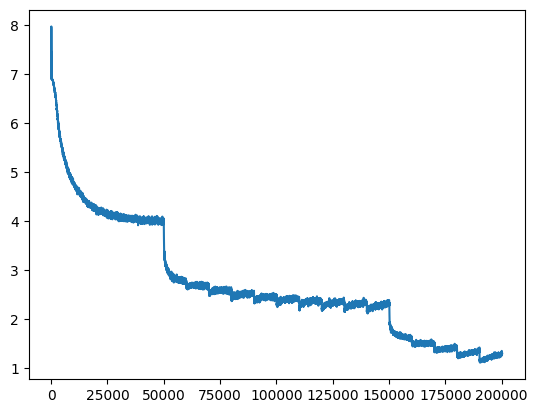

In [ ]:
plt.plot(smooth(losses,50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

In [ ]:
def conv_2_block(in_dim,out_dim):
  model = nn.Sequential(
    nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2)
  )
  return model

def conv_3_block(in_dim,out_dim):
  model = nn.Sequential(
    nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2)
  )
  return model

In [ ]:
class VGG(nn.Module):
  def __init__(self, base_dim, num_classes=10):
    super(VGG, self).__init__()
    self.feature = nn.Sequential(
        conv_2_block(3,base_dim), #64
        conv_2_block(base_dim,2*base_dim), #128
        conv_3_block(2*base_dim,4*base_dim), #256
        conv_3_block(4*base_dim,8*base_dim), #512
        conv_3_block(8*base_dim,8*base_dim), #512
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(8*base_dim*7*7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 1000),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1000, num_classes),
    )

  def forward(self, x):
    x = self.feature(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)
    return x

In [ ]:
net_vgg = VGG(base_dim=64)
losses_vgg = train(net_vgg, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

These code needs too much resources, so I can't finish it

RuntimeError: ignored

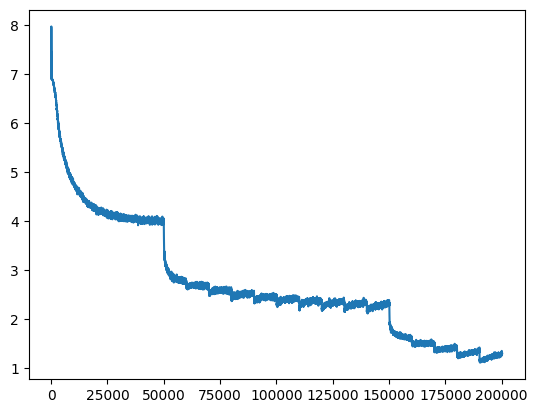

In [ ]:
plt.plot(smooth(losses_vgg,50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

In [ ]:
class DenseNet(nn.Module):
  def __init__(self, num_classes=1000):
    super().__init__()

    self.num_classes = num_classes
    self.growth_rate = 32
    self.base_feature = nn.Sequential(nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                      )

    self.dense_layer1 = nn.Sequential(nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(64, self.growth_rate * 4, 1, bias=False),

                                      nn.BatchNorm2d(self.growth_rate * 4),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(self.growth_rate * 4, self.growth_rate, 3, padding=1, bias=False),
                                      )

    self.dense_layer2 = nn.Sequential(nn.BatchNorm2d(96),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(96, 128, 1, bias=False),

                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, 3, padding=1, bias=False),
                                      )

    self.dense_layer3 = nn.Sequential(nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 128, 1, bias=False),

                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, 3, padding=1, bias=False),
                                      )

    self.dense_layer4 = nn.Sequential(nn.BatchNorm2d(160),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(160, 128, 1, bias=False),

                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, 3, padding=1, bias=False),
                                      )

    self.dense_layer5 = nn.Sequential(nn.BatchNorm2d(192),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(192, 128, 1, bias=False),

                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, 3, padding=1, bias=False),
                                      )

    self.dense_layer6 = nn.Sequential(nn.BatchNorm2d(224),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(224, 128, 1, bias=False),

                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, 3, padding=1, bias=False),
                                      )

    self.transition1 = nn.Sequential(nn.BatchNorm2d(256),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(256, 128, 1, bias=False),
                                     nn.AvgPool2d(kernel_size=2, stride=2)
                                     )

  def forward(self, x):
    x = self.base_feature(x)
    x1 = self.dense_layer1(torch.cat([x], 1))
    x2 = self.dense_layer2(torch.cat([x, x1], 1))
    x3 = self.dense_layer3(torch.cat([x, x1, x2], 1))
    x4 = self.dense_layer4(torch.cat([x, x1, x2, x3], 1))
    x5 = self.dense_layer5(torch.cat([x, x1, x2, x3, x4], 1))
    x6 = self.dense_layer6(torch.cat([x, x1, x2, x3, x4, x5], 1))
    x = self.transition1(torch.cat([x, x1, x2, x3, x4, x5, x6], 1))
    return x

In [ ]:
net = DenseNet()
losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

RuntimeError: ignored

In [ ]:
plt.plot(smooth(losses,50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

###Load Resnet, VGG, Dencenet using HuggingFace

In [ ]:
!rm -rf ~/.cache/torch/ImageNet

In [ ]:
import torch
from torchvision import models, datasets

!wget https://image-net.org/download/ILSVRC/devkit/ILSVRC2012_devkit_t12.tar.gz
!tar -zxvf ILSVRC2012_devkit_t12.tar.gz

train_dataset = datasets.ImageNet("./data", split="train")
val_dataset = datasets.ImageNet("./data", split="val")
test_dataset = datasets.ImageNet("./data", split="test")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

--2023-12-08 05:18:32--  https://image-net.org/download/ILSVRC/devkit/ILSVRC2012_devkit_t12.tar.gz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6846 (6.7K) [text/html]
Saving to: ‘ILSVRC2012_devkit_t12.tar.gz’

ILSVRC2012_devkit_t 100%[===================>]   6.69K  --.-KB/s    in 0.001s  

2023-12-08 05:18:33 (7.25 MB/s) - ‘ILSVRC2012_devkit_t12.tar.gz’ saved [6846/6846]


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


RuntimeError: ignored

In [ ]:
def test_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader):
  for epoch in range(10):
    for images, labels in train_loader:
      outputs = model(images)

      loss = torch.nn.functional.cross_entropy(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    correct = 0
    total = 0
    for images, labels in val_loader:
      outputs = model(images)

      predictions = outputs.argmax(dim=1)

      correct += (predictions == labels).sum().item()
      total += labels.size(0)

    print(f"Epoch {epoch + 1}: Accuracy {correct / total}")

  correct = 0
  total = 0
  for images, labels in test_loader:
    outputs = model(images)

    predictions = outputs.argmax(dim=1)

    correct += (predictions == labels).sum().item()
    total += labels.size(0)

  print("Test Accuracy:", correct / total)

  precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu())

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)